In [1]:
# ==============================
# 데이터 로딩 작업
# ==============================
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

# ==============================
# 시드 고정
# ==============================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ==============================
# 토큰 정의
# ==============================
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"

# ------------------------------
# Dataset 정의 (Reverse 옵션 추가, padding은 collate_fn에서 처리)
# ------------------------------
class DateDataset(Dataset):
    def __init__(self, samples, src_stoi=None, tgt_stoi=None, reverse=True):
        self.samples = samples
        self.reverse = reverse

        # 입력 문자 사전
        if src_stoi is None:
            src_vocab = set("".join(s for s, _ in self.samples))
            src_tokens = [PAD, SOS, EOS] + sorted(src_vocab)
            self.src_stoi = {s: i for i, s in enumerate(src_tokens)}
        else:
            self.src_stoi = src_stoi
        self.src_itos = {i: s for s, i in self.src_stoi.items()}

        # 출력 문자 사전
        if tgt_stoi is None:
            tgt_vocab = set("".join(t for _, t in self.samples))
            tgt_tokens = [PAD, SOS, EOS] + sorted(tgt_vocab)
            self.tgt_stoi = {s: i for i, s in enumerate(tgt_tokens)}
        else:
            self.tgt_stoi = tgt_stoi
        self.tgt_itos = {i: s for s, i in self.tgt_stoi.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        src, tgt = self.samples[idx]

        # Reverse Option 적용
        if self.reverse:
            src = src[::-1]

        # 인덱스 변환 (패딩은 collate_fn에서 처리)
        src_ids = [self.src_stoi[SOS]] + [self.src_stoi[c] for c in src] + [self.src_stoi[EOS]]
        tgt_ids = [self.tgt_stoi[SOS]] + [self.tgt_stoi[c] for c in tgt] + [self.tgt_stoi[EOS]]

        return torch.tensor(src_ids), torch.tensor(tgt_ids), src, tgt


# ------------------------------
# collate_fn: 배치 단위 padding
# ------------------------------
def collate_fn(batch):
    src_batch, tgt_batch, src_strs, tgt_strs = zip(*batch)

    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=train_dataset.src_stoi[PAD])
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=train_dataset.tgt_stoi[PAD])

    return src_batch, tgt_batch, src_strs, tgt_strs


# ==============================
# 데이터셋 불러오기
# ==============================
all_samples = []
with open("date.txt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        src, tgt = line.split("_")
        all_samples.append((src.strip(), tgt.strip()))

train_samples, test_samples = train_test_split(all_samples, test_size=0.2, random_state=42)

train_dataset = DateDataset(train_samples, reverse=False)
test_dataset = DateDataset(test_samples,
                           src_stoi=train_dataset.src_stoi,
                           tgt_stoi=train_dataset.tgt_stoi,
                           reverse=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

# ==============================
# 데이터 예시 출력
# ==============================
for src_batch, tgt_batch, src_strs, tgt_strs in train_loader:
    print("입력 배치 shape:", src_batch.shape)
    print("출력 배치 shape:", tgt_batch.shape)
    print("첫 번째 샘플 원문:", src_strs[0], "→", tgt_strs[0])
    print("첫 번째 입력 인덱스:", src_batch[0][:20].tolist())
    print("첫 번째 출력 인덱스:", tgt_batch[0][:20].tolist())
    break


Device: cuda:8
입력 배치 shape: torch.Size([128, 30])
출력 배치 shape: torch.Size([128, 12])
첫 번째 샘플 원문: feb 11, 2011 → 2011-02-11
첫 번째 입력 인덱스: [1, 43, 42, 39, 3, 7, 7, 4, 3, 8, 6, 7, 7, 2, 0, 0, 0, 0, 0, 0]
첫 번째 출력 인덱스: [1, 6, 4, 5, 5, 3, 4, 6, 3, 5, 5, 2]


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# ==============================
# Encoder
# ==============================
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)  # PAD=0
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

    def forward(self, src):
        # src: [batch, src_len]
        embedded = self.embedding(src)  # [batch, src_len, emb_dim]
        outputs, (hidden, cell) = self.lstm(embedded)  # hidden, cell: [num_layers, batch, hidden_dim]
        return hidden, cell


# ==============================
# Decoder
# ==============================
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        # input: [batch] (토큰 하나)
        input = input.unsqueeze(1)              # [batch, 1]
        embedded = self.embedding(input)        # [batch, 1, emb_dim]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))  # [batch, output_dim]
        return prediction, hidden, cell


# ==============================
# Seq2Seq
# ==============================
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: [batch, src_len]
        trg: [batch, trg_len]
        """
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        input = trg[:, 0]  # 첫 입력 = <SOS>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input = trg[:, t] if teacher_force else top1

        return outputs


In [3]:
#추론 관련 함수

@torch.no_grad()
def greedy_decode_seq2seq(model, src, max_len, tgt_stoi, tgt_itos, debug=False):
    model.eval()
    hidden, cell = model.encoder(src)   # Encoder는 (hidden, cell) 반환

    input_token = torch.tensor([tgt_stoi["<SOS>"]], device=src.device)
    outputs = []

    for t in range(max_len):
        output, hidden, cell = model.decoder(input_token, hidden, cell)  # [1, V]
        top1 = output.argmax(1)

        if debug:
            print(f"Step {t}: {tgt_itos[top1.item()]}")

        if top1.item() == tgt_stoi["<EOS>"]:
            break
        if top1.item() not in (tgt_stoi["<SOS>"], tgt_stoi["<PAD>"]):
            outputs.append(top1.item())

        input_token = top1

    return outputs


@torch.no_grad()
def evaluate_seq2seq(model, x_str, src_stoi, tgt_stoi, tgt_itos, device, max_len=20, debug=False):
    # 문자열 → 인덱스 변환
    x_idx = [src_stoi.get(c, src_stoi["<PAD>"]) for c in x_str]
    src = torch.tensor(x_idx, device=device).unsqueeze(0)  # [1, L]

    # Greedy decoding
    pred_idx = greedy_decode_seq2seq(model, src, max_len, tgt_stoi, tgt_itos, debug=debug)
    pred_str = "".join([tgt_itos[i] for i in pred_idx])
    return pred_str

In [4]:
#하이퍼파라미터 & 모델 초기화

INPUT_DIM = len(train_dataset.src_stoi)
OUTPUT_DIM = len(train_dataset.tgt_stoi)

PAD_IDX = train_dataset.tgt_stoi["<PAD>"]
SOS_IDX = train_dataset.tgt_stoi["<SOS>"]
EOS_IDX = train_dataset.tgt_stoi["<EOS>"]

EMB_DIM = 64          # 임베딩 차원
HIDDEN_DIM = 256      # LSTM 은닉 차원
N_EPOCHS = 50
PATIENCE = 15         # early stopping patience
MIN_DELTA = 1e-3
CLIP = 5.0

# Teacher Forcing Ratio 스케줄링
TF_START = 0.7
TF_END   = 0.3
TF_DECAY = 0.02

enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
model = Seq2Seq(enc, dec, device, PAD_IDX).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
#평가 지표
def token_accuracy_fn(y_pred, y_true, pad_idx):
    pred_tokens = y_pred.argmax(dim=2)  # [B, T]
    mask = (y_true != pad_idx)
    correct = (pred_tokens == y_true) & mask
    acc = correct.sum().float() / mask.sum().float()
    return acc.item()

@torch.no_grad()
@torch.no_grad()
def exact_match_fn(model, dataset, src_stoi, tgt_stoi, tgt_itos, device, n_samples=None):
    """
    n_samples=None → 전체 데이터셋 평가
    n_samples=숫자 → 그 수만큼 랜덤 샘플 평가
    """
    if n_samples is None or n_samples >= len(dataset):
        indices = range(len(dataset))
    else:
        indices = random.sample(range(len(dataset)), n_samples)

    correct = 0
    for idx in indices:
        _, _, src_str, tgt_str = dataset[idx]
        pred_str = evaluate_seq2seq(
            model, src_str,
            src_stoi=src_stoi, tgt_stoi=tgt_stoi, tgt_itos=tgt_itos,
            device=device, max_len=len(tgt_str)+2
        )
        if pred_str.replace(" ", "") == tgt_str:
            correct += 1

    return correct / len(indices)



In [6]:
from tqdm import tqdm

#: 학습 / 평가 함수

def train_one_epoch(model, loader, optimizer, criterion, epoch, clip=5.0):
    model.train()
    total_loss = total_acc = 0.0
    # teacher forcing ratio 선형 감소
    tf_ratio = max(TF_END, TF_START - TF_DECAY * epoch)
    for src, trg, _, _ in tqdm(loader, desc=f"Train Epoch {epoch}", leave=False):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg, teacher_forcing_ratio=1.0)#tf_ratio)

        V = output.shape[-1]
        output_flat = output[:, 1:].reshape(-1, V)
        trg_flat = trg[:, 1:].reshape(-1)

        loss = criterion(output_flat, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        B = src.size(0)
        Tm1 = trg[:, 1:].size(1)
        output_eval = output_flat.view(B, Tm1, V)
        trg_eval = trg[:, 1:]
        acc = token_accuracy_fn(output_eval, trg_eval, pad_idx=PAD_IDX)

        total_loss += loss.item()
        total_acc += acc

    n = len(loader)
    return total_loss / n, total_acc / n



@torch.no_grad()
def evaluate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = total_acc = 0.0

    for src, trg, _, _ in loader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg, teacher_forcing_ratio=0.0)

        V = output.shape[-1]
        output_flat = output[:, 1:].reshape(-1, V)
        trg_flat = trg[:, 1:].reshape(-1)

        loss = criterion(output_flat, trg_flat)

        B = src.size(0)
        Tm1 = trg[:, 1:].size(1)
        output_eval = output_flat.view(B, Tm1, V)
        trg_eval = trg[:, 1:]

        total_loss += loss.item()
        total_acc += token_accuracy_fn(output_eval, trg_eval, pad_idx=PAD_IDX)

    n = len(loader)
    return total_loss / n, total_acc / n


In [7]:
# ==============================
# 학습 루프 (Exact Match 기반 Early Stopping)
# ==============================

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_exact_accs = []   # train_exact_accs [] 제거

best_val_eacc = 0.0
patience_counter = 0

for epoch in range(1, N_EPOCHS + 1):
    # ------------------------------
    # 1) 학습 / 평가
    # ------------------------------
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    va_loss, va_acc = evaluate_one_epoch(model, test_loader, criterion)
    
    # # Train Exact Match는 생략
    # tr_eacc = exact_match_fn(
    #     model, train_dataset,
    #     src_stoi=train_dataset.src_stoi,
    #     tgt_stoi=train_dataset.tgt_stoi,
    #     tgt_itos=train_dataset.tgt_itos,
    #     device=device, n_samples=500
    # )
    #
    #validation은 전체 데이터셋으로 평가
    va_eacc = exact_match_fn(
        model, test_dataset,
        src_stoi=train_dataset.src_stoi,
        tgt_stoi=train_dataset.tgt_stoi,
        tgt_itos=test_dataset.tgt_itos,
        device=device,
        n_samples=None   # None → 전체 데이터 평가
    )

    # ------------------------------
    # 2) 기록
    # ------------------------------
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc); val_accs.append(va_acc)
    val_exact_accs.append(va_eacc)

    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {tr_loss:.5f} | Token Acc: {tr_acc:.5f} || "
          f"Val Loss: {va_loss:.5f} | Token Acc: {va_acc:.5f} | Exact Acc: {va_eacc:.5f} "
          f"(Best Val Exact: {best_val_eacc:.5f}, Patience: {patience_counter})")

    # ------------------------------
    # 3) 샘플 디버그 출력
    # ------------------------------
    if epoch % 1 == 0:
        src_ids, tgt_ids, src_str, tgt_str = random.choice(test_dataset)
        pred = evaluate_seq2seq(
            model, src_str,
            src_stoi=train_dataset.src_stoi,
            tgt_stoi=train_dataset.tgt_stoi,
            tgt_itos=train_dataset.tgt_itos,
            device=device,
            max_len=len(tgt_str) + 2
        )
        print(f"[DEBUG] 입력: {src_str} | 정답: {tgt_str} | 예측: {pred}")

    # ------------------------------
    # 4) Early Stopping (Exact Match 기준)
    # ------------------------------
    if va_eacc > best_val_eacc + MIN_DELTA:
        best_val_eacc = va_eacc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break


Epoch 001 | Train Loss: 0.78237 | Token Acc: 0.71197 || Val Loss: 0.39607 | Token Acc: 0.86993 | Exact Acc: 0.02350 (Best Val Exact: 0.00000, Patience: 0)
[DEBUG] 입력: Tuesday, June 27, 2017 | 정답: 2017-06-27 | 예측: 2017-02-27


Epoch 002 | Train Loss: 0.08402 | Token Acc: 0.97789 || Val Loss: 0.01507 | Token Acc: 0.99893 | Exact Acc: 0.15250 (Best Val Exact: 0.02350, Patience: 0)
[DEBUG] 입력: 10/30/98 | 정답: 1998-10-30 | 예측: 198-10


Epoch 003 | Train Loss: 0.00576 | Token Acc: 0.99988 || Val Loss: 0.00291 | Token Acc: 0.99995 | Exact Acc: 0.18640 (Best Val Exact: 0.15250, Patience: 0)
[DEBUG] 입력: 10/25/13 | 정답: 2013-10-25 | 예측: 201-12-


Epoch 004 | Train Loss: 0.00193 | Token Acc: 0.99999 || Val Loss: 0.00137 | Token Acc: 1.00000 | Exact Acc: 0.20470 (Best Val Exact: 0.18640, Patience: 0)
[DEBUG] 입력: Friday, January 18, 2008 | 정답: 2008-01-18 | 예측: 2008-01-18


Epoch 005 | Train Loss: 0.00535 | Token Acc: 0.99888 || Val Loss: 0.00115 | Token Acc: 1.00000 | Exact Acc: 0.28790 (Best Val Exact: 0.20470, Patience: 0)
[DEBUG] 입력: SEPTEMBER 29, 1978 | 정답: 1978-09-29 | 예측: 1978-09-29


Epoch 006 | Train Loss: 0.00076 | Token Acc: 1.00000 || Val Loss: 0.00058 | Token Acc: 1.00000 | Exact Acc: 0.27290 (Best Val Exact: 0.28790, Patience: 0)
[DEBUG] 입력: May 6, 2012 | 정답: 2012-05-06 | 예측: 201-05-26


Epoch 007 | Train Loss: 0.00044 | Token Acc: 1.00000 || Val Loss: 0.00037 | Token Acc: 1.00000 | Exact Acc: 0.27780 (Best Val Exact: 0.28790, Patience: 1)
[DEBUG] 입력: Feb 19, 1972 | 정답: 1972-02-19 | 예측: 197-22-19


Epoch 008 | Train Loss: 0.00031 | Token Acc: 1.00000 || Val Loss: 0.00027 | Token Acc: 1.00000 | Exact Acc: 0.28180 (Best Val Exact: 0.28790, Patience: 2)
[DEBUG] 입력: SEP 24, 1976 | 정답: 1976-09-24 | 예측: 197-02-14


Epoch 009 | Train Loss: 0.00023 | Token Acc: 1.00000 || Val Loss: 0.00021 | Token Acc: 1.00000 | Exact Acc: 0.28110 (Best Val Exact: 0.28790, Patience: 3)
[DEBUG] 입력: february 1, 1982 | 정답: 1982-02-01 | 예측: 1982-02-15


Epoch 010 | Train Loss: 0.00017 | Token Acc: 1.00000 || Val Loss: 0.00016 | Token Acc: 1.00000 | Exact Acc: 0.27910 (Best Val Exact: 0.28790, Patience: 4)
[DEBUG] 입력: Saturday, June 26, 1993 | 정답: 1993-06-26 | 예측: 1993-06-26


Epoch 011 | Train Loss: 0.00014 | Token Acc: 1.00000 || Val Loss: 0.00013 | Token Acc: 1.00000 | Exact Acc: 0.27850 (Best Val Exact: 0.28790, Patience: 5)
[DEBUG] 입력: friday, may 28, 1999 | 정답: 1999-05-28 | 예측: 1999-05-28


Epoch 012 | Train Loss: 0.00011 | Token Acc: 1.00000 || Val Loss: 0.00010 | Token Acc: 1.00000 | Exact Acc: 0.28150 (Best Val Exact: 0.28790, Patience: 6)
[DEBUG] 입력: Sunday, July 26, 2009 | 정답: 2009-07-26 | 예측: 2009-07-26


Epoch 013 | Train Loss: 0.00009 | Token Acc: 1.00000 || Val Loss: 0.00008 | Token Acc: 1.00000 | Exact Acc: 0.28800 (Best Val Exact: 0.28790, Patience: 7)
[DEBUG] 입력: OCT 7, 1991 | 정답: 1991-10-07 | 예측: 199-10-17


Epoch 014 | Train Loss: 0.00007 | Token Acc: 1.00000 || Val Loss: 0.00007 | Token Acc: 1.00000 | Exact Acc: 0.28140 (Best Val Exact: 0.28790, Patience: 8)
[DEBUG] 입력: Monday, August 28, 1978 | 정답: 1978-08-28 | 예측: 1978-08-28


Epoch 015 | Train Loss: 0.00006 | Token Acc: 1.00000 || Val Loss: 0.00006 | Token Acc: 1.00000 | Exact Acc: 0.28780 (Best Val Exact: 0.28790, Patience: 9)
[DEBUG] 입력: monday, january 7, 1985 | 정답: 1985-01-07 | 예측: 1985-01-17


Epoch 016 | Train Loss: 0.00005 | Token Acc: 1.00000 || Val Loss: 0.00005 | Token Acc: 1.00000 | Exact Acc: 0.28730 (Best Val Exact: 0.28790, Patience: 10)
[DEBUG] 입력: may 18, 1986 | 정답: 1986-05-18 | 예측: 1986-05-18


Epoch 017 | Train Loss: 0.00004 | Token Acc: 1.00000 || Val Loss: 0.00004 | Token Acc: 1.00000 | Exact Acc: 0.28940 (Best Val Exact: 0.28790, Patience: 11)
[DEBUG] 입력: July 29, 1983 | 정답: 1983-07-29 | 예측: 1983-07-29


Epoch 018 | Train Loss: 0.00003 | Token Acc: 1.00000 || Val Loss: 0.00003 | Token Acc: 1.00000 | Exact Acc: 0.29350 (Best Val Exact: 0.28940, Patience: 0)
[DEBUG] 입력: APR 18, 2007 | 정답: 2007-04-18 | 예측: 2007-01-28


Epoch 019 | Train Loss: 0.00003 | Token Acc: 1.00000 || Val Loss: 0.00003 | Token Acc: 1.00000 | Exact Acc: 0.29180 (Best Val Exact: 0.29350, Patience: 0)
[DEBUG] 입력: Feb 15, 2005 | 정답: 2005-02-15 | 예측: 205-021


Epoch 020 | Train Loss: 0.00002 | Token Acc: 1.00000 || Val Loss: 0.00002 | Token Acc: 1.00000 | Exact Acc: 0.29130 (Best Val Exact: 0.29350, Patience: 1)
[DEBUG] 입력: mar 2, 2017 | 정답: 2017-03-02 | 예측: 2017-03-2


Epoch 021 | Train Loss: 0.00002 | Token Acc: 1.00000 || Val Loss: 0.00002 | Token Acc: 1.00000 | Exact Acc: 0.28960 (Best Val Exact: 0.29350, Patience: 2)
[DEBUG] 입력: 4/3/70 | 정답: 1970-04-03 | 예측: 197-05-18


Epoch 022 | Train Loss: 0.00002 | Token Acc: 1.00000 || Val Loss: 0.00002 | Token Acc: 1.00000 | Exact Acc: 0.29320 (Best Val Exact: 0.29350, Patience: 3)
[DEBUG] 입력: Dec 2, 1983 | 정답: 1983-12-02 | 예측: 1983-12-2


Epoch 023 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.29370 (Best Val Exact: 0.29350, Patience: 4)
[DEBUG] 입력: FEBRUARY 9, 1972 | 정답: 1972-02-09 | 예측: 1972-02-19


Epoch 024 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.28520 (Best Val Exact: 0.29350, Patience: 5)
[DEBUG] 입력: jun 27, 2016 | 정답: 2016-06-27 | 예측: 2016-09-27


Epoch 025 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.29010 (Best Val Exact: 0.29350, Patience: 6)
[DEBUG] 입력: TUESDAY, JUNE 17, 1986 | 정답: 1986-06-17 | 예측: 1986-06-17


Epoch 026 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.29400 (Best Val Exact: 0.29350, Patience: 7)
[DEBUG] 입력: 2/28/05 | 정답: 2005-02-28 | 예측: 205-12


Epoch 027 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.29430 (Best Val Exact: 0.29350, Patience: 8)
[DEBUG] 입력: Monday, February 16, 1976 | 정답: 1976-02-16 | 예측: 1976-02-16


Epoch 028 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.29400 (Best Val Exact: 0.29350, Patience: 9)
[DEBUG] 입력: monday, january 4, 1982 | 정답: 1982-01-04 | 예측: 1982-01-04


Epoch 029 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29490 (Best Val Exact: 0.29350, Patience: 10)
[DEBUG] 입력: apr 7, 1996 | 정답: 1996-04-07 | 예측: 1996-04-27


Epoch 030 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29350 (Best Val Exact: 0.29490, Patience: 0)
[DEBUG] 입력: thursday, march 18, 1976 | 정답: 1976-03-18 | 예측: 1976-03-18


Epoch 031 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29790 (Best Val Exact: 0.29490, Patience: 1)
[DEBUG] 입력: August 14, 1970 | 정답: 1970-08-14 | 예측: 1970-08-16


Epoch 032 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29540 (Best Val Exact: 0.29790, Patience: 0)
[DEBUG] 입력: Monday, May 19, 2008 | 정답: 2008-05-19 | 예측: 2008-09-15


Epoch 033 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29810 (Best Val Exact: 0.29790, Patience: 1)
[DEBUG] 입력: 3/19/90 | 정답: 1990-03-19 | 예측: 190-19-29


Epoch 034 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29930 (Best Val Exact: 0.29790, Patience: 2)
[DEBUG] 입력: 7/12/04 | 정답: 2004-07-12 | 예측: 204-01-2


Epoch 035 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29720 (Best Val Exact: 0.29930, Patience: 0)
[DEBUG] 입력: June 15, 2015 | 정답: 2015-06-15 | 예측: 2015-16-25


Epoch 036 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29910 (Best Val Exact: 0.29930, Patience: 1)
[DEBUG] 입력: Apr 5, 1981 | 정답: 1981-04-05 | 예측: 198-04-15


Epoch 037 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29830 (Best Val Exact: 0.29930, Patience: 2)
[DEBUG] 입력: Aug 20, 1995 | 정답: 1995-08-20 | 예측: 1995-02-18


Epoch 038 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30000 (Best Val Exact: 0.29930, Patience: 3)
[DEBUG] 입력: October 10, 2014 | 정답: 2014-10-10 | 예측: 2014-10-19


Epoch 039 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30250 (Best Val Exact: 0.29930, Patience: 4)
[DEBUG] 입력: feb 19, 1994 | 정답: 1994-02-19 | 예측: 1994-12-29


Epoch 040 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.29990 (Best Val Exact: 0.30250, Patience: 0)
[DEBUG] 입력: sunday, june 3, 1979 | 정답: 1979-06-03 | 예측: 1979-06-03


Epoch 041 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30100 (Best Val Exact: 0.30250, Patience: 1)
[DEBUG] 입력: 1/7/11 | 정답: 2011-01-07 | 예측: 197-12-28


Epoch 042 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30190 (Best Val Exact: 0.30250, Patience: 2)
[DEBUG] 입력: February 10, 1986 | 정답: 1986-02-10 | 예측: 1986-02-19


Epoch 043 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30800 (Best Val Exact: 0.30250, Patience: 3)
[DEBUG] 입력: JUL 14, 2005 | 정답: 2005-07-14 | 예측: 2005-01-2


Epoch 044 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30790 (Best Val Exact: 0.30800, Patience: 0)
[DEBUG] 입력: august 25, 2007 | 정답: 2007-08-25 | 예측: 2007-08-25


Epoch 045 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30740 (Best Val Exact: 0.30800, Patience: 1)
[DEBUG] 입력: January 24, 2011 | 정답: 2011-01-24 | 예측: 2011-01-24


Epoch 046 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30550 (Best Val Exact: 0.30800, Patience: 2)
[DEBUG] 입력: 6/30/91 | 정답: 1991-06-30 | 예측: 199-01-23


Epoch 047 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30580 (Best Val Exact: 0.30800, Patience: 3)
[DEBUG] 입력: NOVEMBER 13, 2006 | 정답: 2006-11-13 | 예측: 2006-11-13


Epoch 048 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.30590 (Best Val Exact: 0.30800, Patience: 4)
[DEBUG] 입력: FRIDAY, JUNE 29, 2007 | 정답: 2007-06-29 | 예측: 2007-09-26


Epoch 049 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.31540 (Best Val Exact: 0.30800, Patience: 5)
[DEBUG] 입력: June 26, 1985 | 정답: 1985-06-26 | 예측: 1985-06-21


Epoch 050 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.31180 (Best Val Exact: 0.31540, Patience: 0)
[DEBUG] 입력: august 29, 1999 | 정답: 1999-08-29 | 예측: 1999-08-29


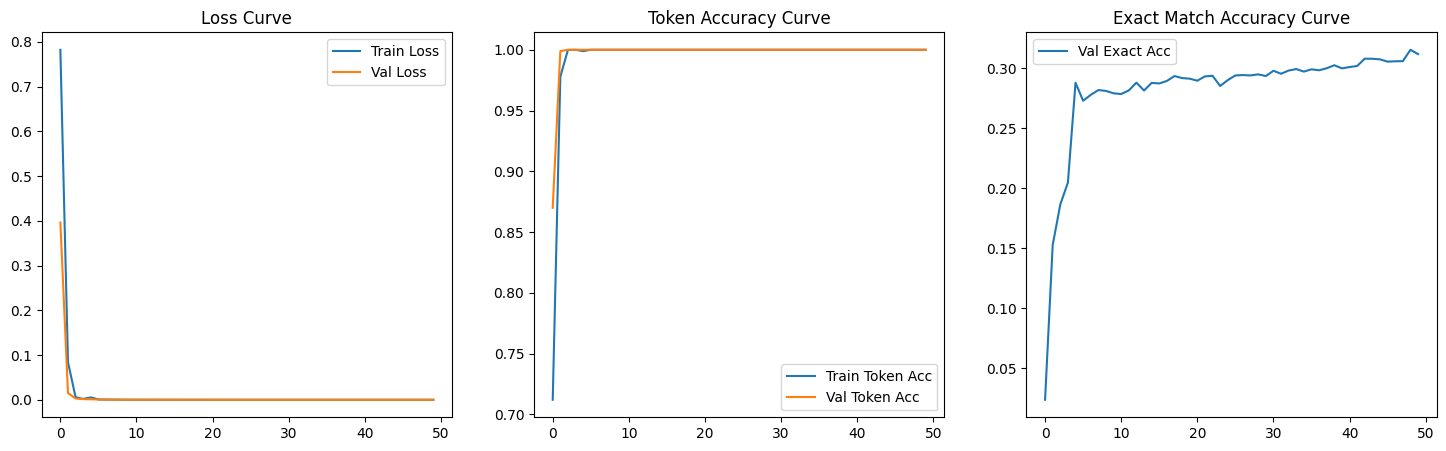

src/tgt stoi/itos 매핑 저장 완료
훈련 결과, 그래프, 모델 가중치, 메타정보를 'results_seq2seq_date_normal' 폴더에 저장했습니다.


In [8]:
###
# ----------------------------------------------------------
# 학습 완료 후 결과 저장
# ----------------------------------------------------------

import os
import json
import matplotlib.pyplot as plt
import pickle


# 저장 디렉토리 생성
save_dir = "results_seq2seq_date_normal"
os.makedirs(save_dir, exist_ok=True)

# 1) 학습 로그 (loss, acc 기록) 저장
history = {
    "train_losses": [float(x) for x in train_losses],
    "val_losses": [float(x) for x in val_losses],
    "train_accs": [float(x) for x in train_accs],
    "val_accs": [float(x) for x in val_accs],
    "val_exact_accs": [float(x) for x in val_exact_accs],
}
with open(os.path.join(save_dir, "history.json"), "w") as f:
    json.dump(history, f, indent=2)

# 2) 학습 곡선 그래프
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Token Acc")
plt.plot(val_accs, label="Val Token Acc")
plt.legend(); plt.title("Token Accuracy Curve")

plt.subplot(1,3,3)
plt.plot(val_exact_accs, label="Val Exact Acc")
plt.legend(); plt.title("Exact Match Accuracy Curve")

plt.savefig(os.path.join(save_dir, "training_curves.png"), dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# 3) 모델 가중치 저장
torch.save(model.state_dict(), os.path.join(save_dir, "results_seq2seq_date_normal.pt"))

# 4) 메타 정보 저장 (옵션)
meta = {
    "input_dim": INPUT_DIM,
    "output_dim": OUTPUT_DIM,
    "emb_dim": EMB_DIM,
    "hidden_dim": HIDDEN_DIM,
    "n_epochs": N_EPOCHS,
    "best_val_exact": max(val_exact_accs) if val_exact_accs else None
}
with open(os.path.join(save_dir, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

    

# 5) stoi / itos 저장
with open(os.path.join(save_dir, "src_stoi.pkl"), "wb") as f:
    pickle.dump(train_dataset.src_stoi, f)
with open(os.path.join(save_dir, "src_itos.pkl"), "wb") as f:
    pickle.dump(train_dataset.src_itos, f)

with open(os.path.join(save_dir, "tgt_stoi.pkl"), "wb") as f:
    pickle.dump(train_dataset.tgt_stoi, f)
with open(os.path.join(save_dir, "tgt_itos.pkl"), "wb") as f:
    pickle.dump(train_dataset.tgt_itos, f)

print("src/tgt stoi/itos 매핑 저장 완료")


print(f"훈련 결과, 그래프, 모델 가중치, 메타정보를 '{save_dir}' 폴더에 저장했습니다.")



In [9]:
# ==============================
# 문자열 정리 함수 (PAD, SOS, EOS 제거)
# ==============================
def clean_str(s: str):
    return s.replace(SOS, "").replace(EOS, "").replace(PAD, "").strip()


# ==============================
# 날짜 변환 예시 출력 (테스트 데이터 랜덤 5개)
# ==============================
@torch.no_grad()
def show_examples_date(model, test_data, n=5):
    indices = random.sample(range(len(test_data)), n)
    print("\n=== 날짜 변환 예시 (Seq2Seq) ===")
    for idx in indices:
        _, _, src_str, tgt_str = test_data[idx]

        pred_raw = evaluate_seq2seq(
            model, src_str,
            src_stoi=train_dataset.src_stoi,
            tgt_stoi=train_dataset.tgt_stoi,
            tgt_itos=train_dataset.tgt_itos,
            device=device,
            max_len=len(tgt_str) + 5
        )

        pred_str = clean_str(pred_raw)
        true_str = clean_str(tgt_str)

        print(f"입력: {src_str:<30} | 정답: {true_str:<12} | 예측: {pred_str:<12}")


# ------------------------------
# 실행: 테스트 데이터 무작위 5개
# ------------------------------
show_examples_date(model, test_dataset, n=5)


# ==============================
# Custom Examples 직접 확인
# ==============================
custom_examples = [
    "september 27, 1994",
    "August 19, 2003",
    "2/10/93",
    "10/31/90",
    "TUESDAY, SEPTEMBER 25, 1984",
    "JUN 17, 2013",
    "april 3, 1996",
    "October 24, 1974"
]

print("\n=== Custom 예시 입력 (Seq2Seq) ===")
for x in custom_examples:
    pred_raw = evaluate_seq2seq(
        model, x,
        src_stoi=train_dataset.src_stoi,
        tgt_stoi=train_dataset.tgt_stoi,
        tgt_itos=train_dataset.tgt_itos,
        device=device,
        max_len=15   # YYYY-MM-DD 형태까지 넉넉히
    )

    pred_str = clean_str(pred_raw)
    print(f"입력: {x:<30} | 예측: {pred_str}")



=== 날짜 변환 예시 (Seq2Seq) ===
입력: AUG 19, 2016                   | 정답: 2016-08-19   | 예측: 2016-09-18  
입력: FRIDAY, JULY 6, 1979           | 정답: 1979-07-06   | 예측: 1979-07-26  
입력: 9/2/81                         | 정답: 1981-09-02   | 예측: 198-09-21   
입력: february 28, 2003              | 정답: 2003-02-28   | 예측: 2003-02-28  
입력: november 29, 1977              | 정답: 1977-11-29   | 예측: 1977-12-19  

=== Custom 예시 입력 (Seq2Seq) ===
입력: september 27, 1994             | 예측: 1994-09-27
입력: August 19, 2003                | 예측: 2003-09-18
입력: 2/10/93                        | 예측: 193-09-12
입력: 10/31/90                       | 예측: 190-13-28
입력: TUESDAY, SEPTEMBER 25, 1984    | 예측: 1984-09-25
입력: JUN 17, 2013                   | 예측: 2013-01-27
입력: april 3, 1996                  | 예측: 1996-04-30
입력: October 24, 1974               | 예측: 1974-10-24
